In [1]:
import os
import PIL
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam_act import GradCAM, GradCAMpp, ScoreCAM
from gradcam_act import EFCAM_margin as EFCAM

os.environ['CUDA_VISIBLE_DEVICES'] = '5'

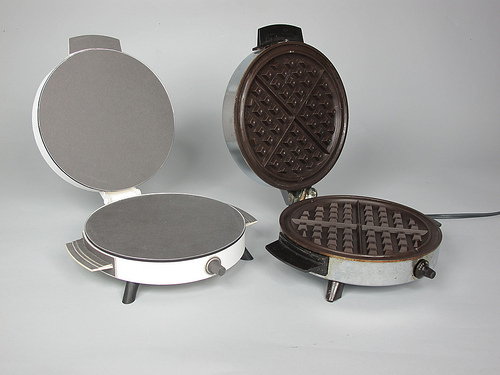

In [2]:
img_dir = 'images'
# img_name = 'collies.JPG'
# img_name = 'multiple_dogs.jpg'
# img_name = 'snake.JPEG'
# img_name = 'water-bird.JPEG'
img_name = 'ILSVRC2012_val_00000797.JPEG'
# img_name = 'Selvaraju et al_2019_Grad-CAM.jpg'
img_path = os.path.join(img_dir, img_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pil_img = PIL.Image.open(img_path)
pil_img

### preprocess image

In [3]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).to(device)
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

ipykernel_launcher:2: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629416375/work/torch/csrc/utils/tensor_numpy.cpp:141.)
/home/n303/anaconda3/envs/xcnn/lib/python3.6/site-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


### Load torchvision models and make model dictionaries

In [4]:
vgg = models.vgg16(pretrained=True)
vgg.eval(), vgg.to(device)

resnet = models.resnet101(pretrained=True)
resnet.eval(), resnet.to(device)

squeezenet = models.squeezenet1_1(pretrained=True)
squeezenet.eval(), squeezenet.to(device)

cam_dict = dict()

vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
vgg_gradcam = GradCAM(vgg_model_dict, True)
vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
vgg_scorecam = ScoreCAM(vgg_model_dict, True)
vgg_efcam = EFCAM(vgg_model_dict, True)

resnet_model_dict = dict(type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
resnet_efcam = EFCAM(resnet_model_dict, True)

squeezenet_model_dict = dict(type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation', input_size=(224, 224))
squeezenet_efcam = EFCAM(squeezenet_model_dict, True)

saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([13, 13])


### Feedforward image, calculate GradCAM/GradCAM++, and gather results

In [5]:
images = []
class_idx = None # 随便取一个和类别无关的, 事实证明，scorecam和ours不受此影响，在多分类时可能会定位失效
mask, _, = vgg_gradcampp(normed_torch_img, class_idx=class_idx)

output_dir = 'sanity'
os.makedirs(output_dir, exist_ok=True)

heatmap, result = visualize_cam(mask, torch_img)

output_path = os.path.join(output_dir, "ori.png")
save_image(torch_img, output_path)
output_path = os.path.join(output_dir, "heatmap.png")
save_image(heatmap, output_path)
output_path = os.path.join(output_dir, "result.png")
save_image(result, output_path)

'''
print(mask.shape)
for i in range(mask.size(1)):
    images = act[:,i:i+1,:,:]
    images = (images - images.min())/(images.max() - images.min()+1e-8)
    images = F.interpolate(images, size=(224, 224), mode='bilinear')
    heatmap = cv2.applyColorMap(np.uint8(255 * images.squeeze().cpu()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    
    output_name = str(i)+".png"
    output_path = os.path.join(output_dir, output_name)

    save_image(heatmap, output_path)
#     PIL.Image.open(output_path)
'''

# for gradcam in cam_dict.values():
#     mask, _ = gradcam(normed_torch_img, class_idx=class_idx)
#     heatmap, result = visualize_cam(mask, torch_img)
    
#     images.append(torch.stack(
#         [torch_img.squeeze().cpu(), heatmap, result], 0))
    
# images = make_grid(torch.cat(images, 0), nrow=3)

'\nprint(mask.shape)\nfor i in range(mask.size(1)):\n    images = act[:,i:i+1,:,:]\n    images = (images - images.min())/(images.max() - images.min()+1e-8)\n    images = F.interpolate(images, size=(224, 224), mode=\'bilinear\')\n    heatmap = cv2.applyColorMap(np.uint8(255 * images.squeeze().cpu()), cv2.COLORMAP_JET)\n    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)\n    b, g, r = heatmap.split(1)\n    heatmap = torch.cat([r, g, b])\n    \n    output_name = str(i)+".png"\n    output_path = os.path.join(output_dir, output_name)\n\n    save_image(heatmap, output_path)\n#     PIL.Image.open(output_path)\n'

### Save and show results

In [6]:
# output_dir = 'outputs'
# os.makedirs(output_dir, exist_ok=True)
# output_name = img_name
# output_path = os.path.join(output_dir, output_name)

# save_image(images, output_path)
# PIL.Image.open(output_path)